[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


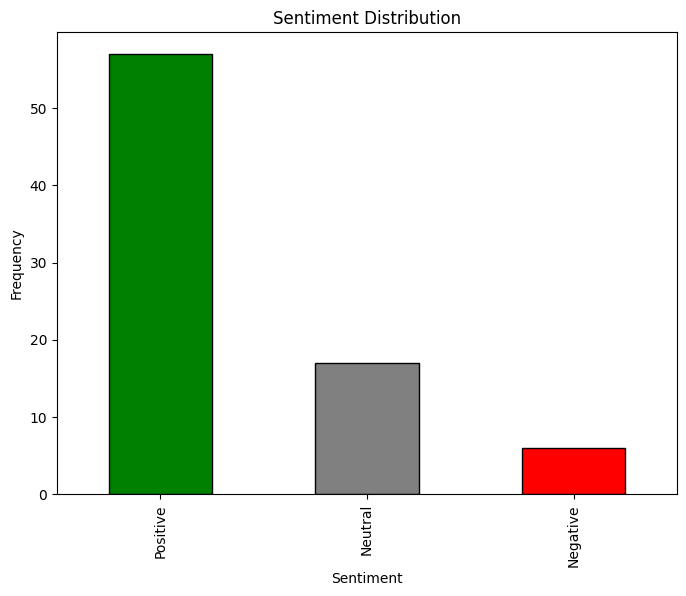

<ipython-input-1-5377c68b5fb4>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['Dominant_Topic'] = [lda_output[idx].argmax() for idx in range(len(negative_reviews))]


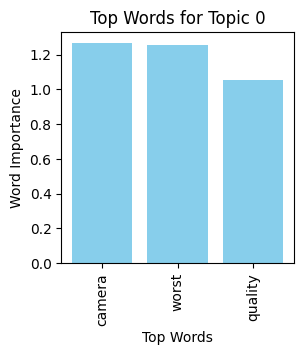

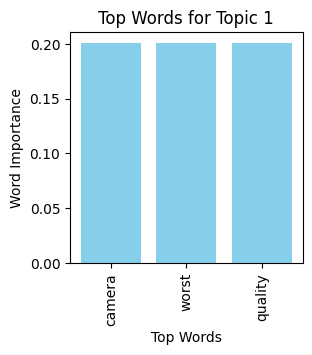

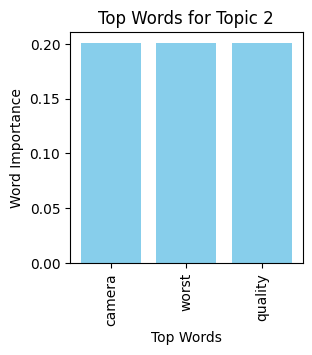

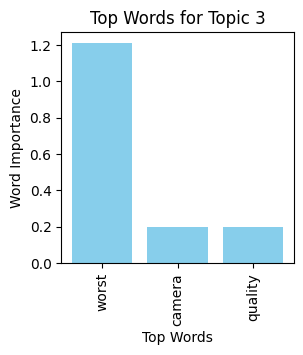

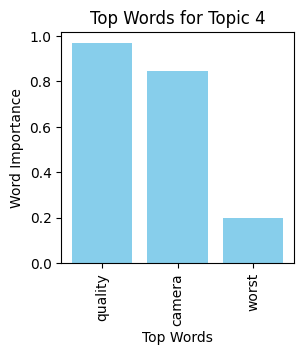


Negative Reviews with Dominant Topics:
                                    reviewDescription  Dominant_Topic
18                                totally waste money               0
30  this oppo mobile very worst mobile terms camer...               0
34             didn work properly camera poor quality               4
35           wrong product life looking worst product               3
40                               camera feature worst               0
57                      like single phone want return               0


In [1]:
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Load the dataset
df = pd.read_csv("amazonsentiments.csv")


# Function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        # Tokenization
        tokens = word_tokenize(text.lower())
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
        return ' '.join(lemmatized_tokens)
    else:
        return ''


# Preprocess the 'reviewDescription' column
df['Cleaned_Reviews'] = df['reviewDescription'].apply(preprocess_text)


# Function to categorize sentiment
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'


# Calculate sentiment polarity
df['Sentiment_Polarity'] = df['Cleaned_Reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)


# Categorize sentiment
df['Sentiment'] = df['Sentiment_Polarity'].apply(categorize_sentiment)


# Plot sentiment distribution
plt.figure(figsize=(8, 6))
df['Sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'], edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()


# Topic Modeling on negative reviews
negative_reviews = df[df['Sentiment'] == "Negative"]
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(negative_reviews['Cleaned_Reviews'])
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(tfidf)


# Get dominant topic for each negative review
negative_reviews['Dominant_Topic'] = [lda_output[idx].argmax() for idx in range(len(negative_reviews))]


# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()


num_topics_to_display = 5
num_words_to_display = 5


for topic_idx in range(num_topics_to_display):
    # Get top words for the topic
    top_words_idx = lda_model.components_[topic_idx].argsort()[:-num_words_to_display-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_word_importance = lda_model.components_[topic_idx][top_words_idx]


    # Plot top words for the topic
    plt.figure(figsize=(3, 3))  # Adjust figure size as needed
    plt.bar(top_words, top_word_importance, color='skyblue')  # Vertical bars
    plt.ylabel('Word Importance')
    plt.xlabel('Top Words')
    plt.title(f'Top Words for Topic {topic_idx}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()




# Print negative reviews with dominant topics
print("\nNegative Reviews with Dominant Topics:")
print(negative_reviews[['reviewDescription', 'Dominant_Topic']])